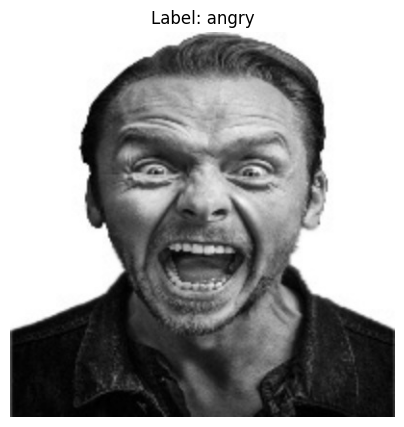

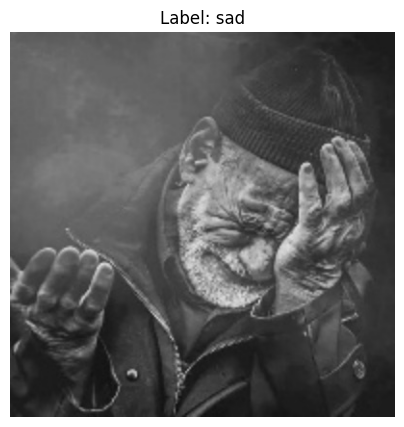

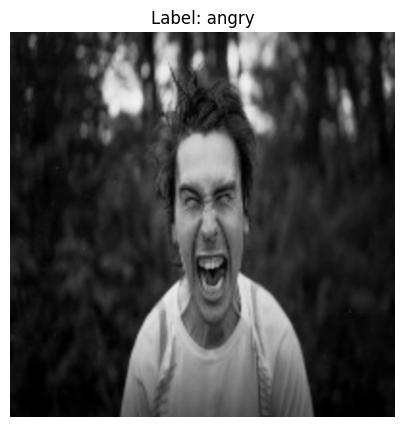

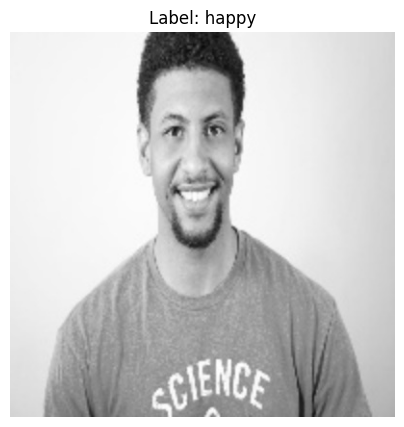

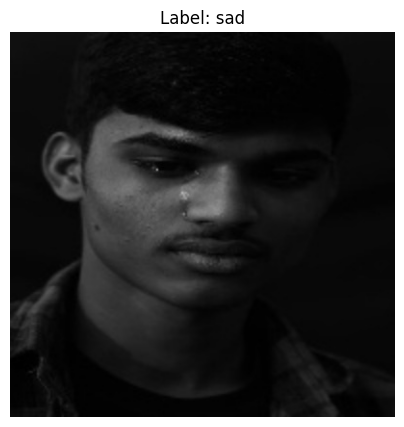

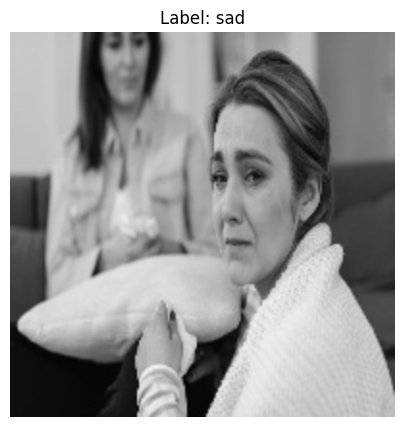

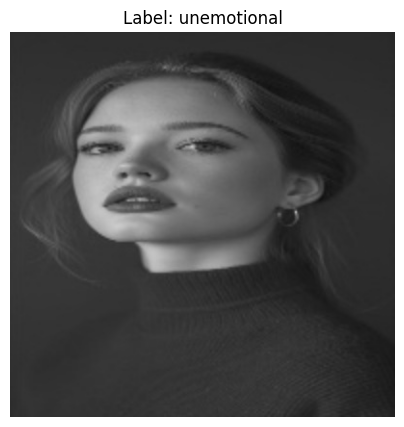

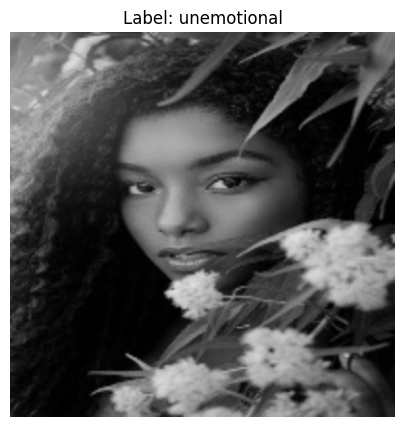

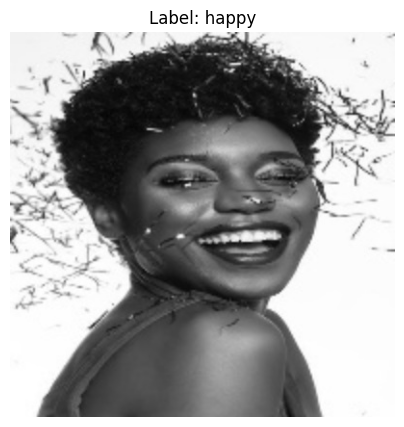

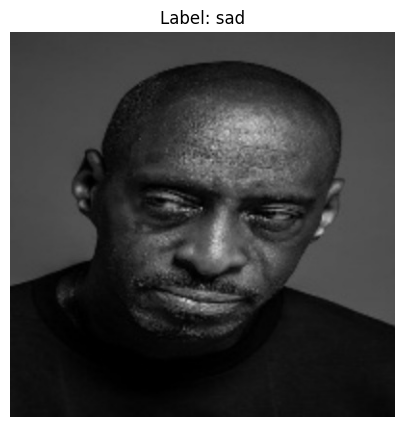

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load dữ liệu từ tệp đã lưu trữ
data = np.load('/kaggle/input/emotion-data/emotion_dataset.npz')
images = data['images']
labels = data['labels']

# Số lượng ảnh bạn muốn hiển thị
num_images_to_display = 10

# In ra các ảnh và nhãn tương ứng
for i in range(num_images_to_display):
    plt.figure(figsize=(5, 5))
    plt.imshow(images[i])
    plt.title('Label: ' + labels[i])
    plt.axis('off')
    plt.show()


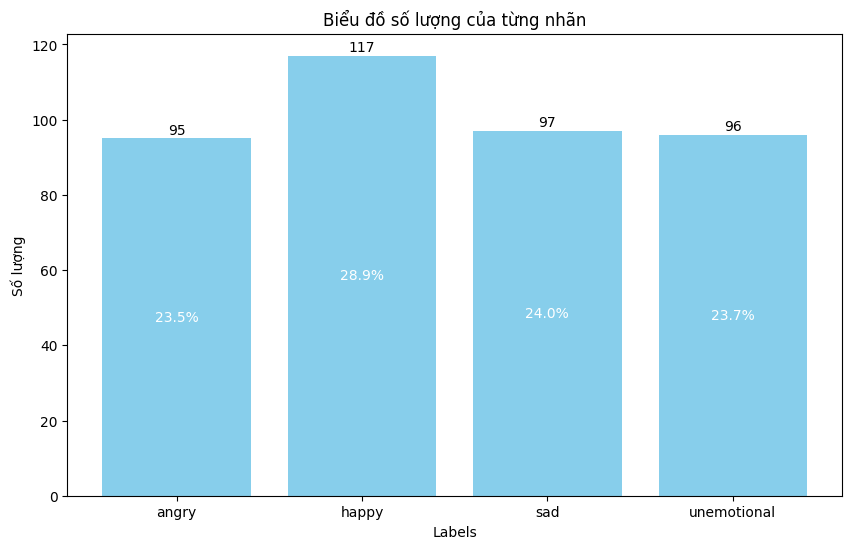

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Đếm số lượng của từng nhãn
unique_labels, counts = np.unique(labels, return_counts=True)
total_samples = np.sum(counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Số lượng')
plt.title('Biểu đồ số lượng của từng nhãn')

# Thêm số lượng của mỗi nhãn lên trên mỗi cột
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, count, ha='center', va='bottom')
    percentage = '{:.1f}%'.format((count / total_samples) * 100)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, percentage, ha='center', va='center', color='white')

plt.xticks(unique_labels)  # Đặt các nhãn trên trục x
plt.show()


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_emotion_data(file_path, val_size=0.1, test_size=0.1, random_state=42):
    # Tải dữ liệu từ tệp npz
    data = np.load(file_path)
    images = data['images']  # Lấy ra mảng chứa các ảnh
    labels = data['labels']  # Lấy ra mảng chứa các nhãn tương ứng với ảnh

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=(test_size + val_size), random_state=random_state)

    # Chia tập kiểm tra thành tập kiểm tra và tập validation
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size/(test_size + val_size), random_state=random_state)

    # Chuyển đổi nhãn về dạng số nguyên để sử dụng trong mô hình
    label_mapping = {'sad': 0, 'unemotional': 1, 'angry': 2, 'happy': 3}  # Ánh xạ các nhãn về số nguyên
    y_train = np.array([label_mapping[label] for label in y_train])  # Chuyển đổi nhãn của tập huấn luyện
    y_val = np.array([label_mapping[label] for label in y_val])  # Chuyển đổi nhãn của tập validation
    y_test = np.array([label_mapping[label] for label in y_test])  # Chuyển đổi nhãn của tập kiểm tra

    # Chuẩn hóa dữ liệu ảnh về khoảng [0, 1]
    X_train = X_train.astype('float32') / 255.0  # Chuẩn hóa dữ liệu ảnh của tập huấn luyện
    X_val = X_val.astype('float32') / 255.0  # Chuẩn hóa dữ liệu ảnh của tập validation
    X_test = X_test.astype('float32') / 255.0  # Chuẩn hóa dữ liệu ảnh của tập kiểm tra

    return X_train, X_val, X_test, y_train, y_val, y_test


In [4]:
def add_custom_layers(pretrained_model):
    # Đóng băng các layers của mô hình đã được huấn luyện
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Thêm lớp mới cho bài toán fine-tuning
    pretrained_model.add(layers.Dense(128, activation='relu'))
    pretrained_model.add(layers.Dropout(0.5))
    pretrained_model.add(layers.Dense(4, activation='softmax'))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_augmentation_generator():
    """
    Tạo đối tượng ImageDataGenerator để tăng cường dữ liệu.

    Returns:
    - datagen: Đối tượng ImageDataGenerator đã được cấu hình.
    """
    # Khởi tạo đối tượng ImageDataGenerator với các tham số tăng cường dữ liệu
    datagen = ImageDataGenerator(rotation_range=20,        # Góc quay ảnh (độ)
                                 width_shift_range=0.2,    # Phạm vi dịch chuyển theo chiều rộng
                                 height_shift_range=0.2,   # Phạm vi dịch chuyển theo chiều cao
                                 shear_range=0.2,          # Phạm vi cắt
                                 zoom_range=0.2,           # Phạm vi thu phóng
                                 horizontal_flip=True,     # Lật ảnh theo chiều ngang
                                 fill_mode='nearest')      # Chế độ điền các điểm ảnh bị trống

    return datagen

# Sử dụng hàm để tạo đối tượng ImageDataGenerator
datagen = create_data_augmentation_generator()

2024-03-31 08:56:36.113467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 08:56:36.113560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 08:56:36.243944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
from tensorflow.keras import callbacks

def create_early_stopping_callback(monitor='val_loss', patience=7, restore_best_weights=True):
    """
    Tạo callback Early Stopping để dừng sớm quá trình huấn luyện khi không cải thiện độ chính xác trên tập validation.

    Args:
    - monitor: Đại lượng được theo dõi để dừng sớm (mặc định là 'val_loss').
    - patience: Số lượng epoch không cải thiện mà ta chấp nhận trước khi dừng sớm (mặc định là 3).
    - restore_best_weights: Có khôi phục trọng số của mô hình về trạng thái tốt nhất không (mặc định là True).

    Returns:
    - early_stopping: Callback Early Stopping đã được cấu hình.
    """
    # Tạo callback Early Stopping
    early_stopping = callbacks.EarlyStopping(monitor=monitor,
                                             patience=patience,
                                             restore_best_weights=restore_best_weights)
    
    return early_stopping
early_stopping = create_early_stopping_callback()

In [7]:
from tensorflow.keras import layers, models

def add_new_layers_for_fine_tuning(base_model, num_units=128, dropout_rate=0.5, num_classes=4, num_layers_to_unfreeze=10):
    """
    Mở các layer cuối cùng của mô hình cơ sở và thêm các lớp mới để thực hiện fine-tuning.

    Args:
    - base_model: Mô hình cơ sở được sử dụng để thêm các lớp mới.
    - num_units: Số đơn vị của lớp Dense mới (mặc định là 128).
    - dropout_rate: Tỷ lệ dropout cho lớp Dropout mới (mặc định là 0.5).
    - num_classes: Số lớp đầu ra của mô hình (mặc định là 4).
    - num_layers_to_unfreeze: Số lượng layer cuối cùng được mở ra để fine-tuning (mặc định là 10).

    Returns:
    - model: Mô hình với các layer cuối cùng đã được mở ra và các lớp mới đã được thêm vào.
    """
    # Mở các layer cuối cùng của mô hình
    for layer in base_model.layers[:-num_layers_to_unfreeze]:
        layer.trainable = False

    # Thêm các lớp mới vào mô hình
    flatten_layer = layers.Flatten()(base_model.output)
    dense_layer = layers.Dense(num_units, activation='relu')(flatten_layer)
    dropout_layer = layers.Dropout(dropout_rate)(dense_layer)
    output_layer = layers.Dense(num_classes, activation='softmax')(dropout_layer)

    # Tạo mô hình mới với các layer đã được mở và các lớp mới đã được thêm vào
    model = models.Model(inputs=base_model.input, outputs=output_layer)

    return model

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Lấy thông tin về loss và accuracy từ history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Vẽ đồ thị loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Vẽ đồ thị accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


## CNN

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Sử dụng hàm preprocess_emotion_data để tiền xử lý dữ liệu
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_emotion_data('/kaggle/input/emotion-data/emotion_dataset.npz', val_size=0.1, test_size=0.1, random_state=42)

In [10]:
from tensorflow.keras import optimizers
# Thiết lập một số tham số mới
new_filters = 32
new_kernel_size = (3, 3)
new_dense_units = 64
new_dropout_rate = 0.5
new_learning_rate = 0.001
new_epochs = 20

# Xây dựng mô hình CNN với các tham số mới
model = models.Sequential([
    layers.Conv2D(new_filters, new_kernel_size, activation='relu', input_shape=(400, 400, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(new_filters, new_kernel_size, activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(new_filters, new_kernel_size, activation='relu'),
    layers.Flatten(),
    layers.Dense(new_dense_units, activation='relu'),
    layers.Dropout(new_dropout_rate),
    layers.Dense(4, activation='softmax')
])

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


2024-03-31 08:56:53.604242: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,32,398,398]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,400,400]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-31 08:56:53.747605: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 475218: 6.34318, expected 5.56787
2024-03-31 08:56:53.747663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 475219: 6.28454, expected 5.50924
2024-03-31 08:56:53.747672: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 475220: 6.39179, expected 5.61649
2024-03-31 08:56:53.747680: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1997 - loss: 12.8414

I0000 00:00:1711875424.359367      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2362 - loss: 13.1252

2024-03-31 08:57:05.822612: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 158410: 7.96522, expected 7.06744
2024-03-31 08:57:05.822680: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 158411: 6.50012, expected 5.60233
2024-03-31 08:57:05.822694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 158412: 7.12032, expected 6.22253
2024-03-31 08:57:05.822705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 158413: 7.25861, expected 6.36082
2024-03-31 08:57:05.822715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 158414: 7.12094, expected 6.22316
2024-03-31 08:57:05.822726: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 158415: 6.96626, expected 6.06847
2024-03-31 08:57:05.822737: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 158416: 6.72906, expected 5.83128
2024-03-31 08:57:05.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.2377 - loss: 12.8498

2024-03-31 08:57:10.502367: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61: 5.91322, expected 5.2178
2024-03-31 08:57:10.502437: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 5.7376, expected 5.04219
2024-03-31 08:57:10.502447: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 101: 5.60761, expected 4.9122
2024-03-31 08:57:10.502455: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 102: 5.38189, expected 4.68647
2024-03-31 08:57:10.502462: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 130: 5.76695, expected 5.07154
2024-03-31 08:57:10.502470: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131: 5.54454, expected 4.84913
2024-03-31 08:57:10.502478: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 218: 5.44655, expected 4.75114
2024-03-31 08:57:10.502486: E external/local_x

11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 800ms/step - accuracy: 0.2390 - loss: 12.6203 - val_accuracy: 0.2500 - val_loss: 3.4455
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.1943 - loss: 2.6760 - val_accuracy: 0.2750 - val_loss: 1.3828
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2824 - loss: 1.3790 - val_accuracy: 0.2750 - val_loss: 1.3845
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2106 - loss: 1.3866 - val_accuracy: 0.2500 - val_loss: 1.3852
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2410 - loss: 1.3861 - val_accuracy: 0.2500 - val_loss: 1.3851
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2263 - loss: 1.3866 - val_accuracy: 0.3000 - val_loss: 1.3852
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2907 - loss: 1.3859 - val_accuracy: 0.3000 - val_loss: 1.3852
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3162 - loss: 1.3849 - val_accuracy: 0.3000 - val_loss:

2024-03-31 08:57:20.663315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8119: 4.30999, expected 3.75378
2024-03-31 08:57:20.663373: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8363: 4.30192, expected 3.7457
2024-03-31 08:57:20.663388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9677: 4.51144, expected 3.95522
2024-03-31 08:57:20.663396: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9936: 4.42045, expected 3.86424
2024-03-31 08:57:20.663438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18138: 4.30999, expected 3.75378
2024-03-31 08:57:20.663447: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18382: 4.30192, expected 3.74571
2024-03-31 08:57:20.663460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19696: 4.51144, expected 3.95522
2024-03-31 08:57:20.663468: E ex

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2622 - loss: 1.3793 
Accuracy on test set: 0.26829269528388977


In [12]:
from tensorflow.keras import optimizers

# Danh sách các giá trị tham số cần thử
filters_list = [64]
kernel_size_list = [(3, 3), (5, 5)]
dense_units_list = [64, 128]
dropout_rate_list = [0.1, 0.2]
epochs = 10

best_accuracy = 0.0
best_model = None
best_params = {}

# Duyệt qua tất cả các giá trị tham số để tìm ra bộ tham số tốt nhất
for filters in filters_list:
    for kernel_size in kernel_size_list:
        for dense_units in dense_units_list:
            for dropout_rate in dropout_rate_list:
                # Xây dựng mô hình với các tham số mới
                model = models.Sequential([
                    layers.Conv2D(filters, kernel_size, activation='relu', input_shape=(400, 400, 3)),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(filters, kernel_size, activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(filters, kernel_size, activation='relu'),
                    layers.Flatten(),
                    layers.Dense(dense_units, activation='relu'),
                    layers.Dropout(dropout_rate),
                    layers.Dense(4, activation='softmax')
                ])

                # Biên dịch mô hình
                optimizer = optimizers.Adam()
                model.compile(optimizer=optimizer,
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

                # Huấn luyện mô hình
                history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val), verbose=0)

                # Đánh giá hiệu suất trên tập kiểm tra
                _, test_accuracy = model.evaluate(X_test, y_test)
                print(f'Filters: {filters}, Kernel Size: {kernel_size}, Dense Units: {dense_units}, Dropout Rate: {dropout_rate}, Test Accuracy: {test_accuracy}')

                # Kiểm tra xem mô hình này có tốt hơn không
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_model = model
                    best_params = {'filters': filters, 'kernel_size': kernel_size, 'dense_units': dense_units, 'dropout_rate': dropout_rate}

print("Best model saved with accuracy:", best_accuracy)
print("Best parameters:", best_params)


W0000 00:00:1711875617.921605      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875618.850028      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.3214 - loss: 1.3828
Filters: 64, Kernel Size: (3, 3), Dense Units: 64, Dropout Rate: 0.1, Test Accuracy: 0.3414634168148041


W0000 00:00:1711875651.645171      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875652.578754      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.3214 - loss: 1.3800
Filters: 64, Kernel Size: (3, 3), Dense Units: 64, Dropout Rate: 0.2, Test Accuracy: 0.3414634168148041


W0000 00:00:1711875687.291719      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875688.222314      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3377 - loss: 1.3314
Filters: 64, Kernel Size: (3, 3), Dense Units: 128, Dropout Rate: 0.1, Test Accuracy: 0.3658536672592163


W0000 00:00:1711875723.009196      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875723.954577      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.3214 - loss: 1.3825
Filters: 64, Kernel Size: (3, 3), Dense Units: 128, Dropout Rate: 0.2, Test Accuracy: 0.3414634168148041


W0000 00:00:1711875762.235115      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875766.314721      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3214 - loss: 1.3809  
Filters: 64, Kernel Size: (5, 5), Dense Units: 64, Dropout Rate: 0.1, Test Accuracy: 0.3414634168148041


W0000 00:00:1711875806.928525      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875807.927336      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.3643 - loss: 4.2505
Filters: 64, Kernel Size: (5, 5), Dense Units: 64, Dropout Rate: 0.2, Test Accuracy: 0.39024388790130615


W0000 00:00:1711875848.384929      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875850.292105      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3481 - loss: 5.0353  
Filters: 64, Kernel Size: (5, 5), Dense Units: 128, Dropout Rate: 0.1, Test Accuracy: 0.3658536672592163


W0000 00:00:1711875890.142191      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711875891.144921      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.3110 - loss: 5.2475
Filters: 64, Kernel Size: (5, 5), Dense Units: 128, Dropout Rate: 0.2, Test Accuracy: 0.3414634168148041
Best model saved with accuracy: 0.39024388790130615
Best parameters: {'filters': 64, 'kernel_size': (5, 5), 'dense_units': 64, 'dropout_rate': 0.2}


In [14]:
from tensorflow.keras import optimizers
# Thiết lập một số tham số mới
new_filters = 64
new_kernel_size = (5, 5)
new_dense_units = 64
new_dropout_rate = 0.2
new_learning_rate = 0.001
new_epochs = 20

# Xây dựng mô hình CNN với các tham số mới
model = models.Sequential([
    layers.Conv2D(new_filters, new_kernel_size, activation='relu', input_shape=(400, 400, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(new_filters, new_kernel_size, activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(new_filters, new_kernel_size, activation='relu'),
    layers.Flatten(),
    layers.Dense(new_dense_units, activation='relu'),
    layers.Dropout(new_dropout_rate),
    layers.Dense(4, activation='softmax')
])

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val))

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.2553 - loss: 15.6940

W0000 00:00:1711876112.084552      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 402ms/step - accuracy: 0.2572 - loss: 15.1104 - val_accuracy: 0.2500 - val_loss: 1.5372
Epoch 2/20


W0000 00:00:1711876113.071685      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.2963 - loss: 1.4265 - val_accuracy: 0.1250 - val_loss: 1.3846
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5581 - loss: 1.2893 - val_accuracy: 0.3500 - val_loss: 1.4108
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5405 - loss: 1.2718 - val_accuracy: 0.2750 - val_loss: 1.5540
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5140 - loss: 1.2016 - val_accuracy: 0.3000 - val_loss: 1.4221
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6238 - loss: 1.0579 - val_accuracy: 0.2500 - val_loss: 2.3396
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.7363 - loss: 0.6581 - val_accuracy: 0.4000 - val_loss: 1.7868
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8815 - loss: 0.3794 - val_accuracy: 0.3500 - val_loss: 3.2514
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9667 - loss: 0.1257 - val_accuracy: 0.3250 - val_

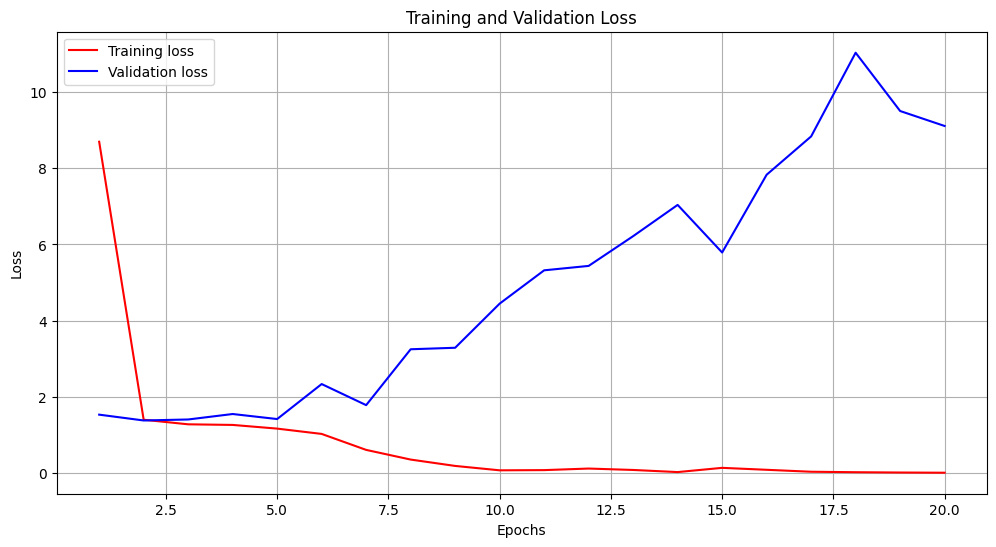

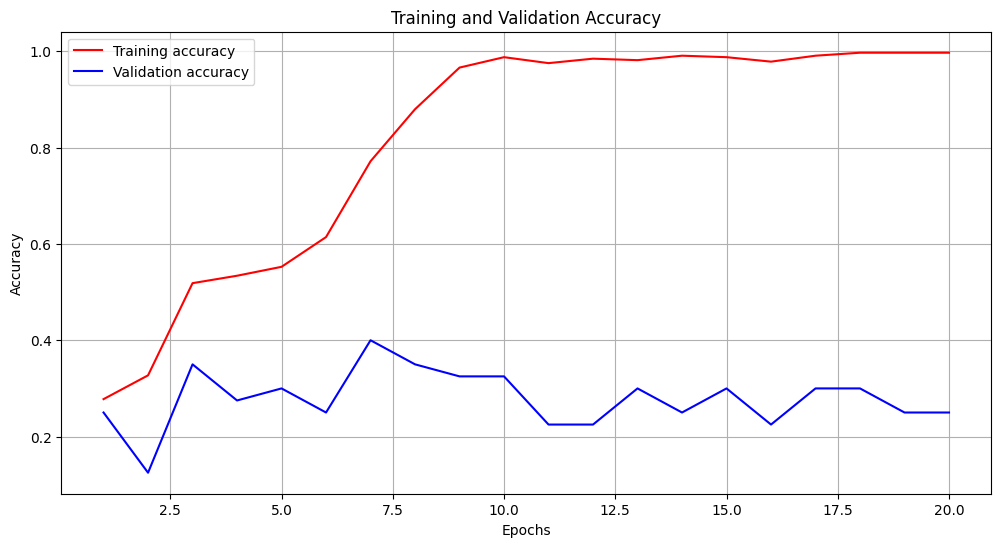

In [15]:
plot_history(history)

## DENSENET

In [16]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import DenseNet121

# Thiết lập một số tham số mới
new_dense_units = 64
new_dropout_rate = 0.1
new_learning_rate = 0.001
new_epochs = 20

# Load mô hình DenseNet121 được huấn luyện trước
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Đóng băng các layers trong mô hình DenseNet121
base_model.trainable = False

# Thêm các lớp tùy chỉnh lên trên DenseNet121
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(new_dense_units, activation='relu')(x)
x = layers.Dropout(new_dropout_rate)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Tạo mô hình
model = models.Model(inputs=base_model.input, outputs=outputs)

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.2521 - loss: 1.4892 - val_accuracy: 0.2750 - val_loss: 1.3490
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.3897 - loss: 1.2913 - val_accuracy: 0.2750 - val_loss: 1.2766
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.4199 - loss: 1.2540 - val_accuracy: 0.3250 - val_loss: 1.2975
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4955 - loss: 1.1479 - val_accuracy: 0.4000 - val_loss: 1.1482
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.5570 - loss: 1.0675 - val_accuracy: 0.5000 - val_loss: 1.1595
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.6177 - loss: 0.9774 - val_accuracy: 0.4750 - val_loss: 1.1041
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.7021 - loss: 0.9234 - val_accuracy: 0.5000 - val_loss: 1.0713
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - a

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers

# Danh sách các giá trị tham số cần thử
dense_units_list = [64, 128]
dropout_rate_list = [0.1, 0.2]
learning_rate_list = [0.001, 0.01]
epochs = 10

best_accuracy = 0.0
best_model = None
best_params = {}

# Duyệt qua tất cả các giá trị tham số để tìm ra bộ tham số tốt nhất
for dense_units in dense_units_list:
    for dropout_rate in dropout_rate_list:
        for learning_rate in learning_rate_list:
            # Xây dựng mô hình với các tham số mới
            base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(400, 400, 3))

            # Đóng băng các layers của mô hình đã được huấn luyện
            for layer in base_model.layers:
                layer.trainable = False

            # Thêm các lớp tùy chỉnh vào mô hình
            x = layers.GlobalAveragePooling2D()(base_model.output)
            x = layers.Dense(dense_units, activation='relu')(x)
            x = layers.Dropout(dropout_rate)(x)
            outputs = layers.Dense(4, activation='softmax')(x)

            model = models.Model(inputs=base_model.input, outputs=outputs)

            # Biên dịch mô hình với tốc độ học mới
            optimizer = optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            # Huấn luyện mô hình
            history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

            # Đánh giá hiệu suất trên tập kiểm tra
            _, test_accuracy = model.evaluate(X_test, y_test)
            print(f'Dense Units: {dense_units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Test Accuracy: {test_accuracy}')

            # Kiểm tra xem mô hình này có tốt hơn không
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_model = model
                best_params = {'dense_units': dense_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print("Best model saved with accuracy:", best_accuracy)
print("Best parameters:", best_params)


In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers

# Danh sách các giá trị tham số cần thử
dense_units_list = [64, 128]
dropout_rate_list = [0.3]
learning_rate_list = [0.001, 0.01]
epochs = 10

best_accuracy = 0.0
best_model = None
best_params = {}

# Duyệt qua tất cả các giá trị tham số để tìm ra bộ tham số tốt nhất
for dense_units in dense_units_list:
    for dropout_rate in dropout_rate_list:
        for learning_rate in learning_rate_list:
            # Xây dựng mô hình với các tham số mới
            base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(400, 400, 3))

            # Đóng băng các layers của mô hình đã được huấn luyện
            for layer in base_model.layers:
                layer.trainable = False

            # Thêm các lớp tùy chỉnh vào mô hình
            x = layers.GlobalAveragePooling2D()(base_model.output)
            x = layers.Dense(dense_units, activation='relu')(x)
            x = layers.Dropout(dropout_rate)(x)
            outputs = layers.Dense(4, activation='softmax')(x)

            model = models.Model(inputs=base_model.input, outputs=outputs)

            # Biên dịch mô hình với tốc độ học mới
            optimizer = optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            # Huấn luyện mô hình
            history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

            # Đánh giá hiệu suất trên tập kiểm tra
            _, test_accuracy = model.evaluate(X_test, y_test)
            print(f'Dense Units: {dense_units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Test Accuracy: {test_accuracy}')

            # Kiểm tra xem mô hình này có tốt hơn không
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_model = model
                best_params = {'dense_units': dense_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print("Best model saved with accuracy:", best_accuracy)
print("Best parameters:", best_params)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3852 - loss: 1.1682  
Dense Units: 64, Dropout Rate: 0.3, Learning Rate: 0.001, Test Accuracy: 0.39024388790130615
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4919 - loss: 1.2745  
Dense Units: 64, Dropout Rate: 0.3, Learning Rate: 0.01, Test Accuracy: 0.4878048896789551
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4385 - loss: 1.3712  
Dense Units: 128, Dropout Rate: 0.3, Learning Rate: 0.001, Test Accuracy: 0.4390243887901306
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3643 - loss: 1.2060  
Dense Units: 128, Dropout Rate: 0.3, Learning Rate: 0.01, Test Accuracy: 0.39024388790130615
Best model saved with accuracy: 0.4878048896789551
Best parameters: {'dense_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01}


In [19]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import DenseNet121

# Thiết lập một số tham số mới
new_dense_units = 128
new_dropout_rate = 0.1
new_learning_rate = 0.001
new_epochs = 20

# Load mô hình DenseNet121 được huấn luyện trước
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Đóng băng các layers trong mô hình DenseNet121
base_model.trainable = False

# Thêm các lớp tùy chỉnh lên trên DenseNet121
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(new_dense_units, activation='relu')(x)
x = layers.Dropout(new_dropout_rate)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Tạo mô hình
model = models.Model(inputs=base_model.input, outputs=outputs)

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val))

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2993 - loss: 1.4482 - val_accuracy: 0.3250 - val_loss: 1.5328
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.3787 - loss: 1.3236 - val_accuracy: 0.3750 - val_loss: 1.3046
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.4287 - loss: 1.1797 - val_accuracy: 0.3750 - val_loss: 1.2130
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.5431 - loss: 1.0819 - val_accuracy: 0.5000 - val_loss: 1.1727
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6158 - loss: 0.9997 - val_accuracy: 0.5250 - val_loss: 1.0806
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6904 - loss: 0.8729 - val_accuracy: 0.4750 - val_loss: 1.1230
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.6940 - loss: 0.8509 - val_accuracy: 0.5500 - val_loss: 1.0152
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.7284 - loss: 0.8119 - val_accuracy: 0.52

In [ ]:
plot_history(history)

## XCEPTION

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import Xception

# Thiết lập một số tham số mới
new_dense_units = 64
new_dropout_rate = 0.1
new_learning_rate = 0.001
new_epochs = 20

# Load mô hình Xception được huấn luyện trước
base_model = Xception(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Đóng băng các layers trong mô hình Xception
base_model.trainable = False

# Thêm các lớp tùy chỉnh lên trên Xception
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(new_dense_units, activation='relu')(x)
x = layers.Dropout(new_dropout_rate)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Tạo mô hình
model = models.Model(inputs=base_model.input, outputs=outputs)

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val))

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
 1/11 ━━━━━━━━━━━━━━━━━━━━ 4:24 26s/step - accuracy: 0.3125 - loss: 1.3809

W0000 00:00:1711877301.967365      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.3183 - loss: 1.3534

W0000 00:00:1711877313.801411      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3208 - loss: 1.3503 - val_accuracy: 0.3750 - val_loss: 1.2657
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5586 - loss: 1.0896 - val_accuracy: 0.4000 - val_loss: 1.2743
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.6333 - loss: 1.0064 - val_accuracy: 0.4250 - val_loss: 1.1836
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.6493 - loss: 0.8584 - val_accuracy: 0.4500 - val_loss: 1.1746
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.7606 - loss: 0.7555 - val_accuracy: 0.4500 - val_loss: 1.1660
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.7860 - loss: 0.7061 - val_accuracy: 0.4000 - val_loss: 1.2851
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.8188 - loss: 0.6202 - val_accuracy: 0.4750 - val_loss: 1.1307
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8273 - loss: 0.5818 - val_accuracy: 0.4500 - val_lo

In [44]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models, optimizers

# Danh sách các giá trị tham số cần thử
dense_units_list = [64, 128]
dropout_rate_list = [0.1, 0.2, 0.3]
learning_rate_list = [0.001, 0.01]
epochs = 10

best_accuracy = 0.0
best_model = None
best_params = {}

# Duyệt qua tất cả các giá trị tham số để tìm ra bộ tham số tốt nhất
for dense_units in dense_units_list:
    for dropout_rate in dropout_rate_list:
        for learning_rate in learning_rate_list:
            # Xây dựng mô hình với các tham số mới
            base_model = Xception(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

            # Đóng băng các layers của mô hình đã được huấn luyện
            for layer in base_model.layers:
                layer.trainable = False

            # Thêm các lớp tùy chỉnh vào mô hình
            x = layers.GlobalAveragePooling2D()(base_model.output)
            x = layers.Dense(dense_units, activation='relu')(x)
            x = layers.Dropout(dropout_rate)(x)
            outputs = layers.Dense(4, activation='softmax')(x)

            model = models.Model(inputs=base_model.input, outputs=outputs)

            # Biên dịch mô hình với tốc độ học mới
            optimizer = optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            # Huấn luyện mô hình
            history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

            # Đánh giá hiệu suất trên tập kiểm tra
            _, test_accuracy = model.evaluate(X_test, y_test)
            print(f'Dense Units: {dense_units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Test Accuracy: {test_accuracy}')

            # Kiểm tra xem mô hình này có tốt hơn không
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_model = model
                best_params = {'dense_units': dense_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print("Best model saved with accuracy:", best_accuracy)
print("Best parameters:", best_params)


W0000 00:00:1711780642.282653      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711780650.454218      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4710 - loss: 1.2061  
Dense Units: 64, Dropout Rate: 0.1, Learning Rate: 0.001, Test Accuracy: 0.4878048896789551


W0000 00:00:1711780688.465217      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711780696.774045      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4444 - loss: 1.4706  
Dense Units: 64, Dropout Rate: 0.1, Learning Rate: 0.01, Test Accuracy: 0.46341463923454285


W0000 00:00:1711780733.569386      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711780742.057230      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4444 - loss: 1.1913  
Dense Units: 64, Dropout Rate: 0.2, Learning Rate: 0.001, Test Accuracy: 0.46341463923454285


W0000 00:00:1711780778.864176      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711780786.954898      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4339 - loss: 1.3883  
Dense Units: 64, Dropout Rate: 0.2, Learning Rate: 0.01, Test Accuracy: 0.46341463923454285


W0000 00:00:1711780825.244754      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711780833.840023      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4710 - loss: 1.2154  
Dense Units: 64, Dropout Rate: 0.3, Learning Rate: 0.001, Test Accuracy: 0.4878048896789551


W0000 00:00:1711780870.513725      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711780878.689379      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4444 - loss: 1.4041  
Dense Units: 64, Dropout Rate: 0.3, Learning Rate: 0.01, Test Accuracy: 0.46341463923454285
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4977 - loss: 1.2413  
Dense Units: 128, Dropout Rate: 0.1, Learning Rate: 0.001, Test Accuracy: 0.5121951103210449
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3910 - loss: 1.6112  
Dense Units: 128, Dropout Rate: 0.1, Learning Rate: 0.01, Test Accuracy: 0.4146341383457184
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4177 - loss: 1.2273  
Dense Units: 128, Dropout Rate: 0.2, Learning Rate: 0.001, Test Accuracy: 0.4390243887901306
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4873 - loss: 1.3563  
Dense Units: 128, Dropout Rate: 0.2, Learning Rate: 0.01, Test Accuracy: 0.5121951103210449
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4118 - loss: 1.4189  
Dense Units: 128, Dropout Rate: 0.3, Learning Rate: 0.001, Test Accuracy: 0.4146341383457184
2/2 ━━━━━━━━━

In [21]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import Xception

# Thiết lập một số tham số mới
new_dense_units = 128
new_dropout_rate = 0.1
new_learning_rate = 0.001
new_epochs = 10

# Load mô hình Xception được huấn luyện trước
base_model = Xception(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Mở khóa một số lớp cuối cùng của mô hình
fine_tune_at = 400
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Thêm các lớp tùy chỉnh lên trên Xception
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(new_dense_units, activation='relu')(x)
x = layers.Dropout(new_dropout_rate)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Tạo mô hình
model = models.Model(inputs=base_model.input, outputs=outputs)

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val))

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2834 - loss: 1.3902 - val_accuracy: 0.4500 - val_loss: 1.3266
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5746 - loss: 1.1050 - val_accuracy: 0.4500 - val_loss: 1.2273
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.6028 - loss: 0.9919 - val_accuracy: 0.3250 - val_loss: 1.3138
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.6684 - loss: 0.8667 - val_accuracy: 0.4500 - val_loss: 1.2153
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.7844 - loss: 0.7090 - val_accuracy: 0.4500 - val_loss: 1.2421
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.7740 - loss: 0.6802 - val_accuracy: 0.4750 - val_loss: 1.1733
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8341 - loss: 0.5662 - val_accuracy: 0.5000 - val_loss: 1.2335
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8554 - loss: 0.4808 - val_accuracy: 0.47

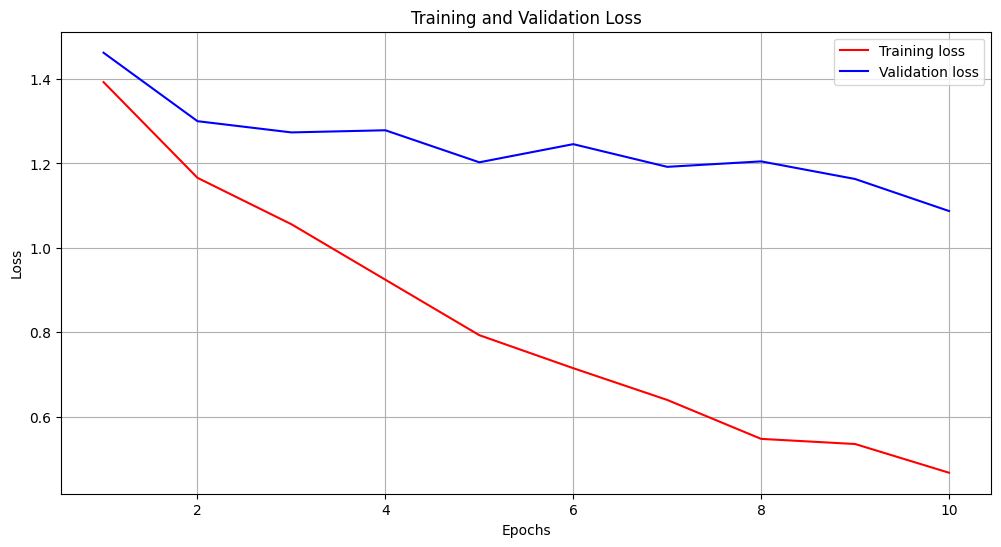

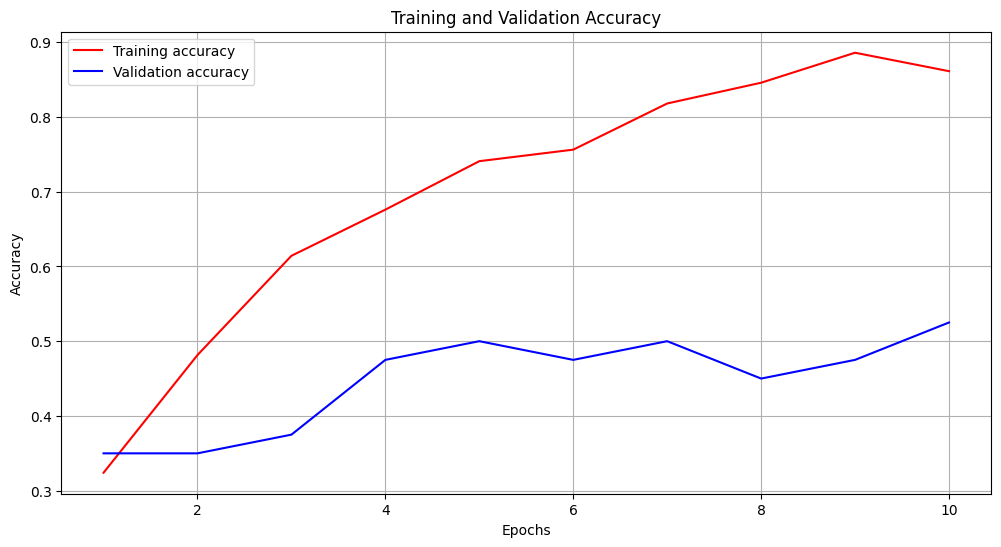

In [14]:
plot_history(history)

## INCEPTIONNET

In [22]:
from tensorflow.keras.applications import InceptionV3

# Thiết lập một số tham số mới
new_dense_units = 64
new_dropout_rate = 0.1
new_learning_rate = 0.001
new_epochs = 20

# Load mô hình InceptionV3 được huấn luyện trước
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Đóng băng các layers trong mô hình InceptionV3
base_model.trainable = False

# Thêm các lớp tùy chỉnh lên trên InceptionV3
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(new_dense_units, activation='relu')(x)
x = layers.Dropout(new_dropout_rate)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Tạo mô hình
model = models.Model(inputs=base_model.input, outputs=outputs)

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val))

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.2969 - loss: 1.5739

W0000 00:00:1711877686.537383      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2570 - loss: 1.5767   

W0000 00:00:1711877704.420433      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.2556 - loss: 1.5719 - val_accuracy: 0.2250 - val_loss: 1.3717
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4437 - loss: 1.2793 - val_accuracy: 0.3500 - val_loss: 1.3469
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5404 - loss: 1.2111 - val_accuracy: 0.3750 - val_loss: 1.3107
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5974 - loss: 1.1179 - val_accuracy: 0.4000 - val_loss: 1.2819
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5342 - loss: 1.0954 - val_accuracy: 0.4250 - val_loss: 1.2179
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5991 - loss: 1.0136 - val_accuracy: 0.5000 - val_loss: 1.2279
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.7052 - loss: 0.8968 - val_accuracy: 0.5000 - val_loss: 1.2275
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6712 - loss: 0.8778 - val_accuracy: 0.5500 - val_lo

In [17]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers

# Danh sách các giá trị tham số cần thử
dense_units_list = [64, 128]
dropout_rate_list = [0.1, 0.2, 0.3]
learning_rate_list = [0.001, 0.01]
epochs = 10

best_accuracy = 0.0
best_model = None
best_params = {}

# Duyệt qua tất cả các giá trị tham số để tìm ra bộ tham số tốt nhất
for dense_units in dense_units_list:
    for dropout_rate in dropout_rate_list:
        for learning_rate in learning_rate_list:
            # Xây dựng mô hình với các tham số mới
            base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

            # Đóng băng các layers của mô hình đã được huấn luyện
            for layer in base_model.layers:
                layer.trainable = False

            # Thêm các lớp tùy chỉnh vào mô hình
            x = layers.GlobalAveragePooling2D()(base_model.output)
            x = layers.Dense(dense_units, activation='relu')(x)
            x = layers.Dropout(dropout_rate)(x)
            outputs = layers.Dense(4, activation='softmax')(x)

            model = models.Model(inputs=base_model.input, outputs=outputs)

            # Biên dịch mô hình với tốc độ học mới
            optimizer = optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            # Huấn luyện mô hình
            history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

            # Đánh giá hiệu suất trên tập kiểm tra
            _, test_accuracy = model.evaluate(X_test, y_test)
            print(f'Dense Units: {dense_units}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Test Accuracy: {test_accuracy}')

            # Kiểm tra xem mô hình này có tốt hơn không
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_model = model
                best_params = {'dense_units': dense_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print("Best model saved with accuracy:", best_accuracy)
print("Best parameters:", best_params)


W0000 00:00:1711787593.550125      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711787605.746217      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4014 - loss: 1.2384  
Dense Units: 64, Dropout Rate: 0.1, Learning Rate: 0.001, Test Accuracy: 0.4146341383457184


W0000 00:00:1711787641.269721      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711787653.606797      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3155 - loss: 1.2130  
Dense Units: 64, Dropout Rate: 0.1, Learning Rate: 0.01, Test Accuracy: 0.31707316637039185


W0000 00:00:1711787692.042033      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711787704.816895      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3643 - loss: 1.2687  
Dense Units: 64, Dropout Rate: 0.2, Learning Rate: 0.001, Test Accuracy: 0.39024388790130615


W0000 00:00:1711787740.120910      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711787752.485802      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4118 - loss: 1.3103  
Dense Units: 64, Dropout Rate: 0.2, Learning Rate: 0.01, Test Accuracy: 0.4146341383457184


W0000 00:00:1711787789.789358      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711787804.057665      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4281 - loss: 1.2510  
Dense Units: 64, Dropout Rate: 0.3, Learning Rate: 0.001, Test Accuracy: 0.4390243887901306


W0000 00:00:1711787840.274692      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711787852.437943      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2680 - loss: 1.3502  
Dense Units: 64, Dropout Rate: 0.3, Learning Rate: 0.01, Test Accuracy: 0.2926829159259796
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4444 - loss: 1.2260  
Dense Units: 128, Dropout Rate: 0.1, Learning Rate: 0.001, Test Accuracy: 0.46341463923454285
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4014 - loss: 1.4773  
Dense Units: 128, Dropout Rate: 0.1, Learning Rate: 0.01, Test Accuracy: 0.4146341383457184
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5081 - loss: 1.1508  
Dense Units: 128, Dropout Rate: 0.2, Learning Rate: 0.001, Test Accuracy: 0.5121951103210449
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2251 - loss: 1.3315  
Dense Units: 128, Dropout Rate: 0.2, Learning Rate: 0.01, Test Accuracy: 0.24390244483947754
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5140 - loss: 1.2157  
Dense Units: 128, Dropout Rate: 0.3, Learning Rate: 0.001, Test Accuracy: 0.5365853905677795
2/2 ━━━━━━━━

In [23]:
from tensorflow.keras.applications import InceptionV3

# Thiết lập một số tham số mới
new_dense_units = 128
new_dropout_rate = 0.3
new_learning_rate = 0.001
new_epochs = 20

# Load mô hình InceptionV3 được huấn luyện trước
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Đóng băng các layers trong mô hình InceptionV3
base_model.trainable = False

# Thêm các lớp tùy chỉnh lên trên InceptionV3
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(new_dense_units, activation='relu')(x)
x = layers.Dropout(new_dropout_rate)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Tạo mô hình
model = models.Model(inputs=base_model.input, outputs=outputs)

# Biên dịch mô hình với tốc độ học mới
optimizer = optimizers.Adam(learning_rate=new_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=new_epochs, validation_data=(X_val, y_val))

# Đánh giá hiệu suất của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_accuracy}')
model.save('/kaggle/working/inception_emotion_model.h5')

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2349 - loss: 1.6657 - val_accuracy: 0.3500 - val_loss: 1.3750
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4562 - loss: 1.2314 - val_accuracy: 0.3500 - val_loss: 1.3378
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5020 - loss: 1.1766 - val_accuracy: 0.4000 - val_loss: 1.3041
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5247 - loss: 1.1228 - val_accuracy: 0.4750 - val_loss: 1.2165
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5915 - loss: 1.0330 - val_accuracy: 0.4500 - val_loss: 1.1799
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6125 - loss: 0.9623 - val_accuracy: 0.4750 - val_loss: 1.2588
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6623 - loss: 0.8868 - val_accuracy: 0.5000 - val_loss: 1.2918
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6818 - loss: 0.8866 - val_accuracy: 0.57